<a href="https://colab.research.google.com/github/AndrewKostin/TUII_2019/blob/master/baseline_08292.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Импортируем нужные библиотеки.

In [0]:
import pandas as pd
from sklearn.metrics import roc_auc_score
import numpy as np
import matplotlib.pyplot as plt


from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Считаем данные по транзакциям и правильные ответы.

In [0]:
transactions_train=pd.read_csv('/content/drive/My Drive/colab/ONTI_FINAL/transactions_train.csv')

In [0]:
train_target=pd.read_csv('/content/drive/My Drive/colab/ONTI_FINAL/train_target.csv')

Посмотрим на данные.

In [0]:
transactions_train.head(5)

,client_dk,trans_date,amount,small_group
0,43976,0,4.563,2
1,8417,0,48.342,0
2,17309,0,12.320,0
3,33523,0,29.005,6
4,24228,0,10.266,6


* client_dk - уникальный идентификатор клиента
* trans_date - дата совершения транзакции
* amount - сумма транзакции
* small_group - категория покупки

In [0]:
train_target.head(5)

,client_dk,27,32,41,45,67,73,81,88
0,39762,1,0,0,0,0,0,0,0
1,10586,0,0,0,1,0,0,0,0
2,40115,0,1,0,0,0,0,0,0
3,34543,0,0,0,1,0,0,0,0
4,5372,0,0,0,1,0,0,0,0


In [0]:
transactions_train.trans_date = transactions_train.trans_date % 7

In [0]:
transactions_train.trans_date.value_counts()


1    3395045
2    3227336
0    3199976
6    3099402
5    3054929
4    3021456
3    2893835
Name: trans_date, dtype: int64

In [0]:
transactions_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21891979 entries, 0 to 21891978
Data columns (total 4 columns):
client_dk      int64
trans_date     int64
amount         float64
small_group    int64
dtypes: float64(1), int64(3)
memory usage: 668.1 MB


In [0]:
dates = transactions_train
dates = dates.groupby(['client_dk','trans_date']).amount.sum().unstack().fillna(0)
dates.head()

trans_date,0,1,2,3,4,5,6
client_dk,,,,,,,
0,1918.715,8792.064,1821.774,1752.422,1513.485,3482.375,2309.641
2,6866.894,6361.272,5706.943,3432.901,5862.168,5395.732,6702.999
3,6385.660,8473.618,8279.075,6682.467,6417.063,6361.427,6415.248
4,6211.318,7981.276,8628.199,7804.861,5562.588,10069.913,5820.484
7,10625.270,18757.032,8277.344,8936.961,9525.660,25736.209,15766.356


Посчитаем по каждому клиенту самые простые аггрегационные признаки.

In [0]:
agg_features=transactions_train.groupby('client_dk')['amount'].agg(['mean','max','min','std','sum','count']).reset_index()

In [0]:
agg_features.head(5)

,client_dk,mean,max,min,std,sum,count
0,0,27.894672,7364.548,0.048,269.495266,21590.476,774
1,2,26.637324,1280.434,0.048,56.031283,40328.909,1514
2,3,52.988711,892.156,0.048,105.198624,49014.558,925
3,4,36.882889,1365.389,0.048,74.227945,52078.639,1412
4,7,123.575737,16678.912,0.048,674.896156,97624.832,790


Посчитаем для каждого клиента количество транзакций по каждой категории.

In [0]:
counter_df_train=transactions_train.groupby(['client_dk','small_group'])['amount'].count()

In [0]:
cat_counts_train=counter_df_train.reset_index().pivot(index='client_dk', \
                                                      columns='small_group',values='amount')

In [0]:
cat_counts_train=cat_counts_train.fillna(0)

In [0]:
cat_counts_train.columns=['small_group_'+str(i) for i in cat_counts_train.columns]

In [0]:
cat_counts_train.head()

,small_group_0,small_group_1,small_group_2,small_group_3,small_group_4,small_group_5,small_group_6,small_group_7,small_group_8,small_group_9,small_group_10,small_group_11,small_group_12,small_group_13,small_group_14,small_group_15,small_group_16,small_group_17,small_group_18,small_group_19,small_group_20,small_group_21,small_group_22,small_group_23,small_group_24,small_group_25,small_group_26,small_group_27,small_group_28,small_group_29,small_group_30,small_group_31,small_group_32,small_group_33,small_group_34,small_group_35,small_group_36,small_group_37,small_group_38,small_group_39,...,small_group_156,small_group_157,small_group_158,small_group_159,small_group_160,small_group_161,small_group_162,small_group_163,small_group_164,small_group_165,small_group_166,small_group_167,small_group_168,small_group_169,small_group_170,small_group_171,small_group_172,small_group_173,small_group_174,small_group_175,small_group_176,small_group_177,small_group_178,small_group_179,small_group_180,small_group_181,small_group_182,small_group_183,small_group_184,small_group_185,small_group_186,small_group_187,small_group_188,small_group_189,small_group_190,small_group_191,small_group_192,small_group_193,small_group_195,small_group_196
client_dk,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,9.0,0.0,27.0,8.0,89.0,119.0,309.0,22.0,0.0,12.0,0.0,15.0,15.0,14.0,15.0,1.0,0.0,0.0,2.0,0.0,3.0,0.0,13.0,15.0,0.0,1.0,2.0,0.0,2.0,0.0,24.0,4.0,7.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,27.0,617.0,196.0,46.0,37.0,114.0,191.0,0.0,1.0,4.0,9.0,79.0,2.0,11.0,3.0,2.0,1.0,0.0,9.0,0.0,1.0,1.0,11.0,0.0,0.0,0.0,0.0,10.0,1.0,2.0,2.0,0.0,2.0,1.0,0.0,8.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,16.0,0.0,1.0,19.0,28.0,174.0,320.0,15.0,0.0,23.0,14.0,20.0,23.0,37.0,18.0,3.0,0.0,5.0,0.0,1.0,24.0,0.0,42.0,0.0,1.0,2.0,9.0,1.0,2.0,0.0,0.0,11.0,3.0,0.0,2.0,2.0,0.0,7.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,21.0,0.0,320.0,50.0,25.0,308.0,105.0,45.0,0.0,46.0,3.0,74.0,16.0,3.0,41.0,18.0,4.0,1.0,20.0,1.0,8.0,0.0,34.0,45.0,0.0,2.0,2.0,2.0,1.0,0.0,2.0,24.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,14.0,0.0,0.0,21.0,0.0,202.0,89.0,1.0,2.0,45.0,11.0,51.0,30.0,0.0,16.0,78.0,3.0,3.0,6.0,1.0,1.0,1.0,35.0,3.0,0.0,5.0,3.0,15.0,1.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Далее соединим все файлы в один датафрейм с таргетом.

In [0]:
train=pd.merge(train_target,agg_features, on='client_dk')
train=pd.merge(train,dates, on='client_dk')
train=pd.merge(train,cat_counts_train.reset_index(),on='client_dk')

In [0]:
train.head()

,client_dk,27,32,41,45,67,73,81,88,mean,max,min,std,sum,count,0,1,2,3,4,5,6,small_group_0,small_group_1,small_group_2,small_group_3,small_group_4,small_group_5,small_group_6,small_group_7,small_group_8,small_group_9,small_group_10,small_group_11,small_group_12,small_group_13,small_group_14,small_group_15,small_group_16,small_group_17,...,small_group_156,small_group_157,small_group_158,small_group_159,small_group_160,small_group_161,small_group_162,small_group_163,small_group_164,small_group_165,small_group_166,small_group_167,small_group_168,small_group_169,small_group_170,small_group_171,small_group_172,small_group_173,small_group_174,small_group_175,small_group_176,small_group_177,small_group_178,small_group_179,small_group_180,small_group_181,small_group_182,small_group_183,small_group_184,small_group_185,small_group_186,small_group_187,small_group_188,small_group_189,small_group_190,small_group_191,small_group_192,small_group_193,small_group_195,small_group_196
0,39762,1,0,0,0,0,0,0,0,22.484556,307.601,0.048,32.723429,24395.743,1085,3223.409,3368.453,4068.925,2779.192,2748.442,4205.491,4001.831,17.0,0.0,2.0,12.0,23.0,414.0,139.0,0.0,0.0,21.0,1.0,18.0,25.0,0.0,43.0,20.0,2.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10586,0,0,0,1,0,0,0,0,21.839333,2313.981,0.048,73.038448,26796.862,1227,3310.183,4230.028,3352.817,2867.908,2997.949,3037.903,7000.074,12.0,54.0,87.0,5.0,277.0,164.0,278.0,51.0,0.0,4.0,0.0,97.0,1.0,0.0,7.0,18.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,40115,0,1,0,0,0,0,0,0,26.915832,737.851,0.048,50.650327,15207.445,565,3088.989,2533.329,2539.694,2248.869,1970.433,1411.790,1414.341,11.0,0.0,29.0,6.0,21.0,162.0,145.0,13.0,0.0,8.0,0.0,73.0,5.0,2.0,3.0,2.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,34543,0,0,0,1,0,0,0,0,98.260840,2360.261,1.402,193.845396,70059.979,713,10304.401,12189.450,7591.792,7496.127,10700.564,12890.741,8886.904,9.0,0.0,143.0,13.0,1.0,119.0,114.0,29.0,0.0,14.0,1.0,42.0,16.0,0.0,21.0,0.0,12.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5372,0,0,0,1,0,0,0,0,12.089445,524.668,0.096,28.664883,8099.928,670,1106.719,1048.841,913.008,1000.011,1180.139,1640.094,1211.116,22.0,0.0,18.0,5.0,36.0,189.0,265.0,4.0,0.0,2.0,0.0,11.0,0.0,0.0,44.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Теперь подгрузим тестовые данные для того, чтобы сделать предсказание. Проделаем с ними те же самые манипуляции, как и с обучающими данными.

In [0]:
transactions_test=pd.read_csv('/content/drive/My Drive/colab/ONTI_FINAL/transactions_test.csv')

Также загрузим id тестовых клиентов, по которым нужно сделать предсказание.

In [0]:
test_id=pd.read_csv('/content/drive/My Drive/colab/ONTI_FINAL/test.csv')

In [0]:
transactions_test.trans_date = transactions_test.trans_date % 7

In [0]:
transactions_test.trans_date.value_counts()

1    3399356
2    3224659
0    3201476
6    3103201
5    3058403
4    3024648
3    2889737
Name: trans_date, dtype: int64

In [0]:
dates_test = transactions_test
dates_test = dates_test.groupby(['client_dk','trans_date']).amount.sum().unstack().fillna(0)
dates_test.head()

trans_date,0,1,2,3,4,5,6
client_dk,,,,,,,
1,4380.825,5968.321,4645.511,7080.179,3830.713,6351.241,7119.139
5,6414.394,4468.862,5209.743,5213.414,2207.733,4179.241,7190.042
6,1304.388,2218.085,1982.538,1647.697,1689.279,1478.653,1833.841
8,397.754,306.318,504.270,570.940,940.259,449.809,243.035
9,4621.120,3224.739,4478.953,6082.249,2131.211,5091.245,4209.376


In [0]:
agg_features_test=transactions_test.groupby('client_dk')['amount'].agg(['mean','max','min','std','sum','count']).reset_index()

In [0]:
counter_df_test=transactions_test.groupby(['client_dk','small_group'])['amount'].count()

In [0]:
cat_counts_test=counter_df_test.reset_index().pivot(index='client_dk', \
                                                      columns='small_group',values='amount')

In [0]:
cat_counts_test=cat_counts_test.fillna(0)

In [0]:
cat_counts_test.columns=['small_group_'+str(i) for i in cat_counts_test.columns]

In [0]:
cat_counts_test.head()

,small_group_0,small_group_1,small_group_2,small_group_3,small_group_4,small_group_5,small_group_6,small_group_7,small_group_8,small_group_9,small_group_10,small_group_11,small_group_12,small_group_13,small_group_14,small_group_15,small_group_16,small_group_17,small_group_18,small_group_19,small_group_20,small_group_21,small_group_22,small_group_23,small_group_24,small_group_25,small_group_26,small_group_27,small_group_28,small_group_29,small_group_30,small_group_31,small_group_32,small_group_33,small_group_34,small_group_35,small_group_36,small_group_37,small_group_38,small_group_39,...,small_group_156,small_group_157,small_group_158,small_group_159,small_group_160,small_group_161,small_group_162,small_group_163,small_group_164,small_group_165,small_group_166,small_group_167,small_group_168,small_group_169,small_group_170,small_group_171,small_group_172,small_group_173,small_group_174,small_group_175,small_group_176,small_group_177,small_group_178,small_group_179,small_group_180,small_group_181,small_group_182,small_group_183,small_group_184,small_group_185,small_group_186,small_group_187,small_group_188,small_group_189,small_group_190,small_group_191,small_group_192,small_group_193,small_group_195,small_group_196
client_dk,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,13.0,0.0,314.0,3.0,164.0,194.0,182.0,20.0,0.0,5.0,5.0,86.0,2.0,0.0,9.0,0.0,1.0,0.0,66.0,0.0,1.0,0.0,13.0,19.0,2.0,1.0,1.0,3.0,3.0,0.0,2.0,0.0,5.0,0.0,1.0,3.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,27.0,0.0,56.0,28.0,13.0,32.0,32.0,276.0,0.0,5.0,0.0,4.0,4.0,0.0,1.0,0.0,141.0,1.0,1.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,23.0,31.0,84.0,2.0,14.0,168.0,38.0,5.0,0.0,3.0,0.0,30.0,0.0,1.0,3.0,17.0,4.0,0.0,6.0,1.0,3.0,0.0,7.0,9.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,4.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,3.0,0.0,18.0,10.0,14.0,54.0,27.0,0.0,0.0,1.0,0.0,0.0,0.0,6.0,3.0,0.0,0.0,0.0,17.0,0.0,0.0,7.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,16.0,0.0,13.0,8.0,5.0,111.0,30.0,0.0,0.0,12.0,1.0,9.0,34.0,1.0,13.0,16.0,0.0,0.0,1.0,1.0,0.0,2.0,38.0,9.0,4.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,17.0,0.0,1.0,2.0,0.0,8.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
test=pd.merge(test_id[['client_dk']],agg_features_test,on='client_dk')
test=pd.merge(test ,dates_test,on='client_dk')
test=pd.merge(test,cat_counts_test.reset_index(),on='client_dk')

In [0]:
test.head()

,client_dk,mean,max,min,std,sum,count,0,1,2,3,4,5,6,small_group_0,small_group_1,small_group_2,small_group_3,small_group_4,small_group_5,small_group_6,small_group_7,small_group_8,small_group_9,small_group_10,small_group_11,small_group_12,small_group_13,small_group_14,small_group_15,small_group_16,small_group_17,small_group_18,small_group_19,small_group_20,small_group_21,small_group_22,small_group_23,small_group_24,small_group_25,...,small_group_156,small_group_157,small_group_158,small_group_159,small_group_160,small_group_161,small_group_162,small_group_163,small_group_164,small_group_165,small_group_166,small_group_167,small_group_168,small_group_169,small_group_170,small_group_171,small_group_172,small_group_173,small_group_174,small_group_175,small_group_176,small_group_177,small_group_178,small_group_179,small_group_180,small_group_181,small_group_182,small_group_183,small_group_184,small_group_185,small_group_186,small_group_187,small_group_188,small_group_189,small_group_190,small_group_191,small_group_192,small_group_193,small_group_195,small_group_196
0,12671,32.394752,1040.564,0.088,63.677712,45741.390,1412,4890.134,7619.008,8553.235,8594.730,5227.095,5721.181,5136.007,47.0,97.0,143.0,61.0,65.0,172.0,492.0,46.0,7.0,3.0,0.0,68.0,1.0,3.0,16.0,42.0,0.0,0.0,15.0,15.0,4.0,3.0,10.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,14015,10.149010,146.297,0.048,16.116614,5297.783,522,1244.037,932.712,382.830,243.861,745.459,1158.766,590.118,1.0,0.0,4.0,6.0,21.0,94.0,87.0,2.0,0.0,6.0,1.0,11.0,8.0,217.0,5.0,0.0,7.0,0.0,4.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1500,64.929581,4955.994,0.048,271.234063,46035.073,709,5346.151,5567.536,3531.664,3215.446,5339.474,14017.263,9017.539,95.0,0.0,63.0,58.0,3.0,70.0,155.0,29.0,0.0,1.0,0.0,11.0,0.0,0.0,2.0,77.0,0.0,0.0,0.0,8.0,0.0,7.0,14.0,0.0,1.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4934,57.945661,3306.661,0.048,169.595259,59973.759,1035,6572.792,7695.038,11317.663,6055.197,10035.505,7178.010,11119.554,15.0,0.0,34.0,31.0,4.0,173.0,366.0,0.0,26.0,1.0,5.0,82.0,4.0,0.0,18.0,99.0,0.0,0.0,6.0,14.0,2.0,2.0,22.0,1.0,1.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,11405,20.921339,512.810,0.003,33.445971,8096.558,387,1065.860,1511.111,2181.631,774.749,388.324,550.232,1624.651,13.0,20.0,12.0,9.0,6.0,163.0,21.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,28.0,0.0,0.0,11.0,19.0,0.0,3.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
train.head()

,client_dk,27,32,41,45,67,73,81,88,mean,max,min,std,sum,count,0,1,2,3,4,5,6,small_group_0,small_group_1,small_group_2,small_group_3,small_group_4,small_group_5,small_group_6,small_group_7,small_group_8,small_group_9,small_group_10,small_group_11,small_group_12,small_group_13,small_group_14,small_group_15,small_group_16,small_group_17,...,small_group_156,small_group_157,small_group_158,small_group_159,small_group_160,small_group_161,small_group_162,small_group_163,small_group_164,small_group_165,small_group_166,small_group_167,small_group_168,small_group_169,small_group_170,small_group_171,small_group_172,small_group_173,small_group_174,small_group_175,small_group_176,small_group_177,small_group_178,small_group_179,small_group_180,small_group_181,small_group_182,small_group_183,small_group_184,small_group_185,small_group_186,small_group_187,small_group_188,small_group_189,small_group_190,small_group_191,small_group_192,small_group_193,small_group_195,small_group_196
0,39762,1,0,0,0,0,0,0,0,22.484556,307.601,0.048,32.723429,24395.743,1085,3223.409,3368.453,4068.925,2779.192,2748.442,4205.491,4001.831,17.0,0.0,2.0,12.0,23.0,414.0,139.0,0.0,0.0,21.0,1.0,18.0,25.0,0.0,43.0,20.0,2.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10586,0,0,0,1,0,0,0,0,21.839333,2313.981,0.048,73.038448,26796.862,1227,3310.183,4230.028,3352.817,2867.908,2997.949,3037.903,7000.074,12.0,54.0,87.0,5.0,277.0,164.0,278.0,51.0,0.0,4.0,0.0,97.0,1.0,0.0,7.0,18.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,40115,0,1,0,0,0,0,0,0,26.915832,737.851,0.048,50.650327,15207.445,565,3088.989,2533.329,2539.694,2248.869,1970.433,1411.790,1414.341,11.0,0.0,29.0,6.0,21.0,162.0,145.0,13.0,0.0,8.0,0.0,73.0,5.0,2.0,3.0,2.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,34543,0,0,0,1,0,0,0,0,98.260840,2360.261,1.402,193.845396,70059.979,713,10304.401,12189.450,7591.792,7496.127,10700.564,12890.741,8886.904,9.0,0.0,143.0,13.0,1.0,119.0,114.0,29.0,0.0,14.0,1.0,42.0,16.0,0.0,21.0,0.0,12.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5372,0,0,0,1,0,0,0,0,12.089445,524.668,0.096,28.664883,8099.928,670,1106.719,1048.841,913.008,1000.011,1180.139,1640.094,1211.116,22.0,0.0,18.0,5.0,36.0,189.0,265.0,4.0,0.0,2.0,0.0,11.0,0.0,0.0,44.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
common_features=list(set(train.columns).intersection(set(test.columns)))

In [0]:
X_train=train[common_features]
X_test=test[common_features]

In [0]:
import seaborn as sns
stuff = cat_counts_train.T.loc[["small_group_27", "small_group_32", "small_group_41", "small_group_45", "small_group_67","small_group_73", "small_group_81", "small_group_88"]]

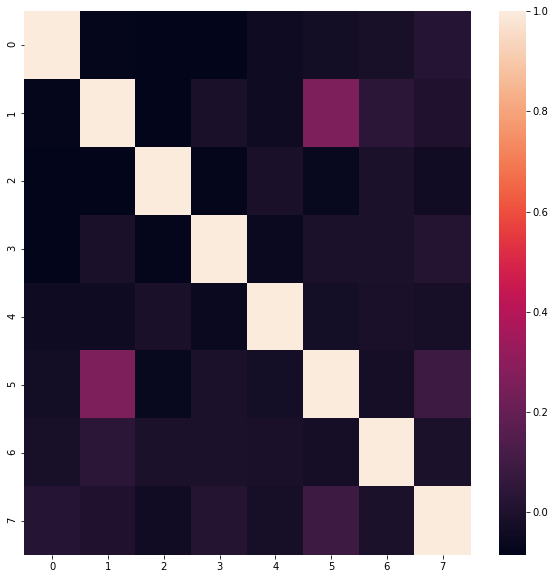

In [0]:
corr = np.corrcoef(stuff)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr, ax=ax)

In [0]:
"client_dk" in X_train.columns

True

In [0]:
X_train = X_train.drop("client_dk", axis=1)
X_test = X_test.drop("client_dk", axis=1)

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
     X_train, train_target, test_size=0.15, random_state=0)

In [0]:
%pip install catboost
from catboost import CatBoostClassifier, cv

In [0]:
%%time
cat = CatBoostClassifier(iterations=1500, learning_rate=0.04, random_seed=63, \
                         loss_function='MultiClass', eval_metric='AUC', \
                         use_best_model=True, depth=6, l2_leaf_reg=1, bagging_temperature=1,\
                         random_strength=0.8, leaf_estimation_method='Newton',\
                         metric_period=100\
                         #task_type='GPU'\
                         )

CPU times: user 58 µs, sys: 5 µs, total: 63 µs
Wall time: 71.8 µs


In [0]:
train_target.head()

,client_dk,27,32,41,45,67,73,81,88
0,39762,1,0,0,0,0,0,0,0
1,10586,0,0,0,1,0,0,0,0
2,40115,0,1,0,0,0,0,0,0
3,34543,0,0,0,1,0,0,0,0
4,5372,0,0,0,1,0,0,0,0


In [0]:
test.head()

,client_dk,mean,max,min,std,sum,count,0,1,2,3,4,5,6,small_group_0,small_group_1,small_group_2,small_group_3,small_group_4,small_group_5,small_group_6,small_group_7,small_group_8,small_group_9,small_group_10,small_group_11,small_group_12,small_group_13,small_group_14,small_group_15,small_group_16,small_group_17,small_group_18,small_group_19,small_group_20,small_group_21,small_group_22,small_group_23,small_group_24,small_group_25,...,small_group_156,small_group_157,small_group_158,small_group_159,small_group_160,small_group_161,small_group_162,small_group_163,small_group_164,small_group_165,small_group_166,small_group_167,small_group_168,small_group_169,small_group_170,small_group_171,small_group_172,small_group_173,small_group_174,small_group_175,small_group_176,small_group_177,small_group_178,small_group_179,small_group_180,small_group_181,small_group_182,small_group_183,small_group_184,small_group_185,small_group_186,small_group_187,small_group_188,small_group_189,small_group_190,small_group_191,small_group_192,small_group_193,small_group_195,small_group_196
0,12671,32.394752,1040.564,0.088,63.677712,45741.390,1412,4890.134,7619.008,8553.235,8594.730,5227.095,5721.181,5136.007,47.0,97.0,143.0,61.0,65.0,172.0,492.0,46.0,7.0,3.0,0.0,68.0,1.0,3.0,16.0,42.0,0.0,0.0,15.0,15.0,4.0,3.0,10.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,14015,10.149010,146.297,0.048,16.116614,5297.783,522,1244.037,932.712,382.830,243.861,745.459,1158.766,590.118,1.0,0.0,4.0,6.0,21.0,94.0,87.0,2.0,0.0,6.0,1.0,11.0,8.0,217.0,5.0,0.0,7.0,0.0,4.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1500,64.929581,4955.994,0.048,271.234063,46035.073,709,5346.151,5567.536,3531.664,3215.446,5339.474,14017.263,9017.539,95.0,0.0,63.0,58.0,3.0,70.0,155.0,29.0,0.0,1.0,0.0,11.0,0.0,0.0,2.0,77.0,0.0,0.0,0.0,8.0,0.0,7.0,14.0,0.0,1.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4934,57.945661,3306.661,0.048,169.595259,59973.759,1035,6572.792,7695.038,11317.663,6055.197,10035.505,7178.010,11119.554,15.0,0.0,34.0,31.0,4.0,173.0,366.0,0.0,26.0,1.0,5.0,82.0,4.0,0.0,18.0,99.0,0.0,0.0,6.0,14.0,2.0,2.0,22.0,1.0,1.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,11405,20.921339,512.810,0.003,33.445971,8096.558,387,1065.860,1511.111,2181.631,774.749,388.324,550.232,1624.651,13.0,20.0,12.0,9.0,6.0,163.0,21.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,28.0,0.0,0.0,11.0,19.0,0.0,3.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
%%time
#В словарь будем записывать предсказания модели
cats = {}
#Цикл со второго элемента, потому что первой колонкой идет идентификатор клиента 
for q in train_target.columns[1:]:
    print('train product '+str(q))
    cat.fit(X_train, y_train.loc[:,q], eval_set=(X_test, y_test.loc[:,q]))
    #Сделаем предсказание
    pred = cat.predict_proba(test.drop("client_dk",axis=1))
    cats[q] = pred

train product 27
0:	test: 0.7561421	best: 0.7561421 (0)	total: 106ms	remaining: 2m 39s
100:	test: 0.8526987	best: 0.8526987 (100)	total: 5.8s	remaining: 1m 20s
200:	test: 0.8523994	best: 0.8526987 (100)	total: 11.1s	remaining: 1m 11s
300:	test: 0.8521621	best: 0.8526987 (100)	total: 16.4s	remaining: 1m 5s
400:	test: 0.8515412	best: 0.8526987 (100)	total: 21.7s	remaining: 59.5s
500:	test: 0.8515274	best: 0.8526987 (100)	total: 26.9s	remaining: 53.7s
600:	test: 0.8510737	best: 0.8526987 (100)	total: 32.3s	remaining: 48.3s
700:	test: 0.8510320	best: 0.8526987 (100)	total: 37.6s	remaining: 42.9s
800:	test: 0.8509491	best: 0.8526987 (100)	total: 43.1s	remaining: 37.6s
900:	test: 0.8508501	best: 0.8526987 (100)	total: 48.5s	remaining: 32.2s
1000:	test: 0.8513167	best: 0.8526987 (100)	total: 53.9s	remaining: 26.9s
1100:	test: 0.8514782	best: 0.8526987 (100)	total: 59.4s	remaining: 21.5s
1200:	test: 0.8514209	best: 0.8526987 (100)	total: 1m 4s	remaining: 16.1s
1300:	test: 0.8516648	best: 0.852

### Подготовим файл для отправки в систему

In [0]:
submission = pd.DataFrame(data=np.zeros((25000,8)),columns=train_target.columns[1:],index=test_id['client_dk'].values)

In [0]:
1 - cats['27']

array([[0.05731456, 0.94268544],
       [0.052013  , 0.947987  ],
       [0.06108432, 0.93891568],
       ...,
       [0.05566174, 0.94433826],
       [0.05339883, 0.94660117],
       [0.63637546, 0.36362454]])

In [0]:
for q in cats:
    submission[q] = (1 - cats[q])
submission.columns = ['cat_27','cat_32','cat_41','cat_45','cat_67','cat_73','cat_81','cat_88']

In [0]:
submission.index.name = 'client_dk'

Сохраняем прогноз на диск в папку submissions. Имя прогноза соответсвует дате и времени его создания, закодированными с помощью timestamp.

In [0]:
submission.to_csv("2.csv", index=True)

Теперь все готово! Можно отправлять решение.